In [2]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from matplotlib import image 
import time
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  # Import Line2D class
from matplotlib.cm import ScalarMappable
from PIL import Image
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [3]:
left_camera_matrix = np.load("calibration_param/left_camera_matrix.npy")
left_distortion_coeffs = np.load("calibration_param/left_distortion_coeffs.npy")
right_camera_matrix = np.load("calibration_param/right_camera_matrix.npy")
right_distortion_coeffs = np.load("calibration_param/right_distortion_coeffs.npy")
left_projection_matrix = np.load("calibration_param/left_proj_mat.npy")
left_rectification_matrix = np.load("calibration_param/left_rectification_mat.npy")
right_projection_matrix = np.load("calibration_param/right_proj_mat.npy")
right_rectification_matrix = np.load("calibration_param/right_rectification_mat.npy")
stereo_rot = np.load("calibration_param/stereo_rot.npy")
stereo_trans = np.load("calibration_param/stereo_translation.npy")
Q = np.load("calibration_param/Q.npy")

In [4]:
def plotting(img1, img2, v_value=None, h_value=None):
    # Plotting
    if v_value==None:
        v_value = img1.shape[1]//2
    if h_value==None:
        h_value = img1.shape[0]//2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Plot left image
    axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Left Image')
    # Plot right image
    axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Right Image')
    # Draw horizontal and vertical lines
    for ax in axes:
        ax.axhline(y=h_value, color='r', linestyle='--')  # Horizontal line
        ax.axvline(x=v_value, color='r', linestyle='--')  # Vertical line
    plt.show()

In [5]:
def save_half_frames(images):
    selected_images = []
    for i in range(len(images)):
        if i % 2 == 0:
            selected_images.append(images[i])
    return selected_images

In [6]:
def save_BW_img(cap):
    image= []
    while True:
  # Lire l'image suivante de la vidéo
        ret, frame = cap.read()

  # Vérifier si la fin de la vidéo a été atteinte
        if not ret:
            break

  # Convertir l'image en noir et blanc
        img_gray= cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        image.append(img_gray)
    cv2.destroyAllWindows()
    cap.release() 
    return image

In [7]:
cap0 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/arve_d.MP4")
cap1 = cv2.VideoCapture("/Users/nilsmanni/Desktop/MA2/design_project/arve_g.MP4")
#cap0 = cv2.VideoCapture("C:/Users/rosas/Documents/Epfl/MA_2/Design Project/Neu/Videos_neu/Left2.MP4")
#cap1 = cv2.VideoCapture("C:/Users/rosas/Documents/Epfl/MA_2/Design Project/Neu/Videos_neu/Right2.MP4")

img_l = save_BW_img(cap0)
#img_l = img_l[:len(img_l)//3]
#img_l= save_half_frames(img_l)

img_r = save_BW_img(cap1)
#img_r = img_r[:len(img_r)//3]
#img_r = save_half_frames(img_r)

images = [img_l, img_r]
#images = [img_l[0], img_r[0]]

In [8]:
print(len(img_l))

0


In [9]:
plotting(images[0][0], images[1][0])

IndexError: list index out of range

In [ ]:
# Specify the desired dimensions
desired_width = 4000
desired_height = 3000
undistorted_l= []
undistorted_r= []
# Check if resizing is needed and resize if necessary
#for image_l, image_r in images:
for camera in range(len(images)):
    for image in images[camera]: 
        if image.shape[1] != desired_width or image.shape[0] != desired_height:
            image = cv2.resize(image, (desired_width, desired_height))
        # Undistort left and right images
        if camera == 0: 
            undistorted_l.append(cv2.undistort(image, left_camera_matrix, left_distortion_coeffs))
        if camera == 1: 
            undistorted_r.append(cv2.undistort(image, right_camera_matrix, right_distortion_coeffs))


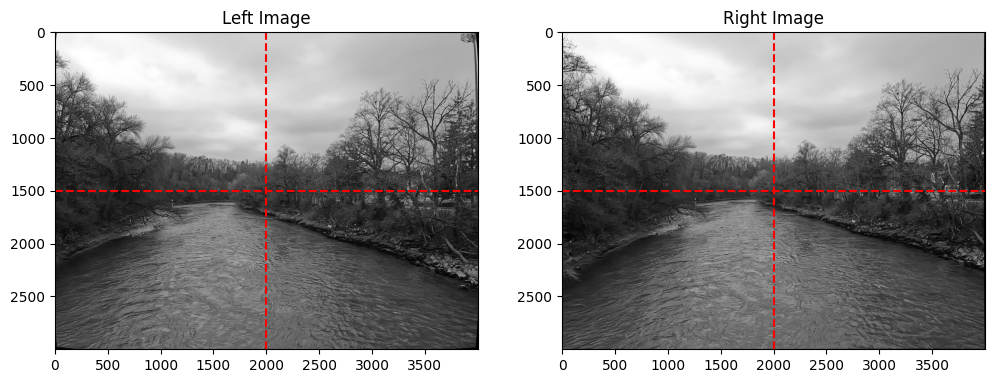

In [ ]:
plotting(undistorted_l[1], undistorted_r[1])

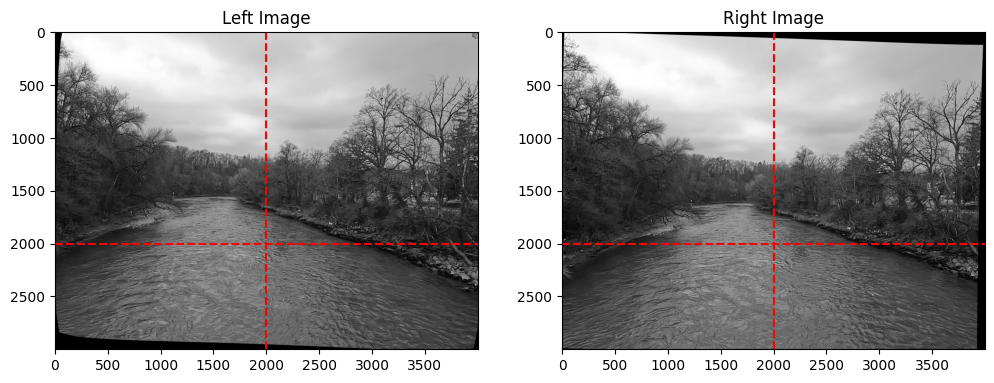

In [ ]:
# Rectify left and right images
mapx_left, mapy_left = cv2.initUndistortRectifyMap(left_camera_matrix, left_distortion_coeffs, left_rectification_matrix, 
                                                   left_projection_matrix, (undistorted_l[0].shape[1],undistorted_l[0].shape[0]), 
                                                   cv2.CV_32F)

mapx_right, mapy_right = cv2.initUndistortRectifyMap(right_camera_matrix, right_distortion_coeffs, right_rectification_matrix, 
                                                     right_projection_matrix,(undistorted_r[0].shape[1],undistorted_r[0].shape[0]), 
                                                     cv2.CV_32F)

rectified_left =[]
rectified_right =[]
for i in range(len(undistorted_r)):
    rectified_left.append(cv2.remap(undistorted_l[i], mapx_left, mapy_left, cv2.INTER_LINEAR).astype(np.uint8))
    rectified_right.append(cv2.remap(undistorted_r[i], mapx_right, mapy_right, cv2.INTER_LINEAR).astype(np.uint8))
plotting(rectified_left[0], rectified_right[0], h_value=2000)

#rectified = []
#rectified.append(rectified_left)
#rectified.append(rectified_right)

In [ ]:
# Define the y-axis range
start_y = 1750
end_y = 2250

# define the x-axis range
start_x = 0
end_x = 4000
# Define the size of the stripe
stripe_height = end_y - start_y
stripe_width = end_x - start_x

#imgs_stripes = []
stripes_l = []
stripes_r = []

# Loop through the images and select the stripe for each image
for img in rectified_left:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    stripes_l.append(selected_stripe)

for img in rectified_right:
    # Convert the image to a numpy array
    img_array = np.array(img)

    # Select the stripe using array slicing
    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
    stripes_r.append(selected_stripe)

# Now, 'stripes' is a list containing the selected stripes from each image

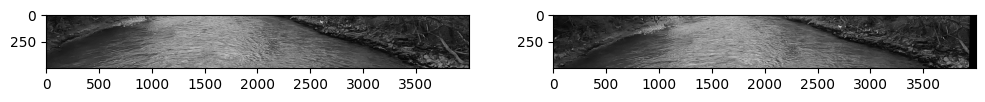

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
ax[0].imshow(stripes_l[0], cmap = 'gray')
ax[1].imshow(stripes_r[0], cmap = 'gray')

In [ ]:
def see_match(images, point1, point2, size=20):
    """
    Display cutout regions from two images centered around given points.
    
    Args:
    - images (list): List containing two images.
    - point1 (tuple): Coordinates (x, y) of the point in the first image.
    - point2 (tuple): Coordinates (x, y) of the corresponding point in the second image.
    - size (int): Size of the cutout region.
    """
    image1, image2 = images

    # Convert images to numpy arrays
    img_array1 = np.array(image1)
    img_array2 = np.array(image2)

    # Extract coordinates of the cutout region
    x1, y1 = point1
    x2, y2 = point2
    start_x1 = max(0, int(x1 - size / 2))
    start_y1 = max(0, int(y1 - size / 2))
    end_x1 = min(img_array1.shape[1], int(x1 + size / 2))
    end_y1 = min(img_array1.shape[0], int(y1 + size / 2))

    start_x2 = max(0, int(x2 - size / 2))
    start_y2 = max(0, int(y2 - size / 2))
    end_x2 = min(img_array2.shape[1], int(x2 + size / 2))
    end_y2 = min(img_array2.shape[0], int(y2 + size / 2))

    # Extract cutout regions from both images
    image_cut1 = img_array1[start_y1:end_y1, start_x1:end_x1]
    image_cut2 = img_array2[start_y2:end_y2, start_x2:end_x2]

    # Display cutout regions side by side
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # Create a figure with four subplots

    # Plot original images
    axes[0, 0].imshow(img_array1, cmap='gray')
    axes[0, 0].scatter(x1, y1, c='red', s=10)  # Add red point to the original image
    axes[0, 0].set_title("Original Image 1")
    axes[0, 1].imshow(img_array2, cmap='gray')
    axes[0, 1].scatter(x2, y2, c='red', s=10)  # Add red point to the original image
    axes[0, 1].set_title("Original Image 2")

    # Plot cutout regions from the first image
    axes[1, 0].imshow(image_cut1, cmap='gray')
    axes[1, 0].scatter(size / 2, size / 2, color='r', s=10)
    axes[1, 0].set_title("Zoomed Image 1")

    # Plot cutout regions from the second image
    axes[1, 1].imshow(image_cut2, cmap='gray')
    axes[1, 1].scatter(size / 2, size / 2, color='r', s=10)
    axes[1, 1].set_title("Zoomed Image 2")

    plt.tight_layout()
    plt.show()




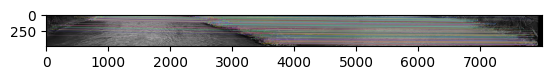

(908,)


In [ ]:
# Function to perform SIFT matching for a pair of images
def sift_matching(img1, img2, min_matches=10, ratio=0.6):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for both images
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Initialize BFMatcher
    bf = cv2.BFMatcher()

    # Match descriptors using k-nearest neighbors
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)

    # Filter matches based on the minimum number required
    if len(good_matches) < min_matches:
        return None
    
    # Convert the list of tuples to a NumPy array
    matched_keypoints = np.array(good_matches)

    # Draw matches
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return img3, matched_keypoints, kp1,kp2

imgs_stripes = []
imgs_stripes.append(stripes_l[0])
imgs_stripes.append(stripes_r[0])

# Perform SIFT matching
img3, matched_keypoints, kp1,kp2 = sift_matching(imgs_stripes[0], imgs_stripes[1])
# Display the result
#plt.imshow(img3), plt.show()

# Display the result
if matched_keypoints is not None:
    plt.imshow(img3)
    plt.show()
else:
    print("Not enough matches found.")
print(matched_keypoints.shape)

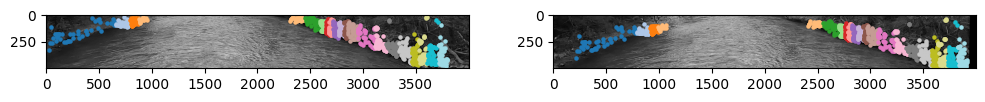

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with two subplots
x1=[]
y1=[]
x2=[]
y2=[]
# Plot for the first image with corners
axes[0].imshow(imgs_stripes[0], cmap='gray')
# Plot the corners with unique colors
for i, match in enumerate(matched_keypoints):
    query_idx = match.queryIdx
    x, y = kp1[query_idx].pt
    x1.append(x)
    y1.append(y)
    color = plt.cm.tab20(i / len(matched_keypoints))  # Choose a color from the 'tab20' colormap
    axes[0].scatter(x, y, color=color, s=5)  # Label the first corner

# Plot for the second image with tracked keypoints
axes[1].imshow(imgs_stripes[1], cmap='gray')
# Plot the tracked keypoints with unique colors
for i, match in enumerate(matched_keypoints):
    train_idx = match.trainIdx
    x, y = kp2[train_idx].pt
    x2.append(x)
    y2.append(y)
    color = plt.cm.tab20(i / len(matched_keypoints))  # Choose a color from the 'tab20' colormap
    axes[1].scatter(x, y, color=color, s=5)  # Label the first tracked keypoint

plt.show()


In [ ]:
# Get the coordinates of all the matched points
points = np.column_stack([x1, y1, x2, y2])
print(points.shape)
print(points[0])

(908, 4)
[ 28.05555916 330.04025269 217.2230072  405.08139038]


In [ ]:
# Compute the difference in the x value and the y values 

x_diff = points[:, 0] - points[:, 2]  # x1 - x2
y_diff = points[:, 1] - points[:, 3]  # y1 - y2

# Combine x_diff and y_diff into a new array
points_more = np.column_stack((points, x_diff, y_diff))
print(points_more.shape)

# Filter the points after their difference in y coordinates
filtered_points = np.array([0,0,0,0,0,0])
for i in range(points_more.shape[0]):
    if np.absolute(points_more[i, 5]) < 300:
        filtered_points = np.vstack((filtered_points, points_more[i]))

print(filtered_points.shape)

(908, 6)
(909, 6)


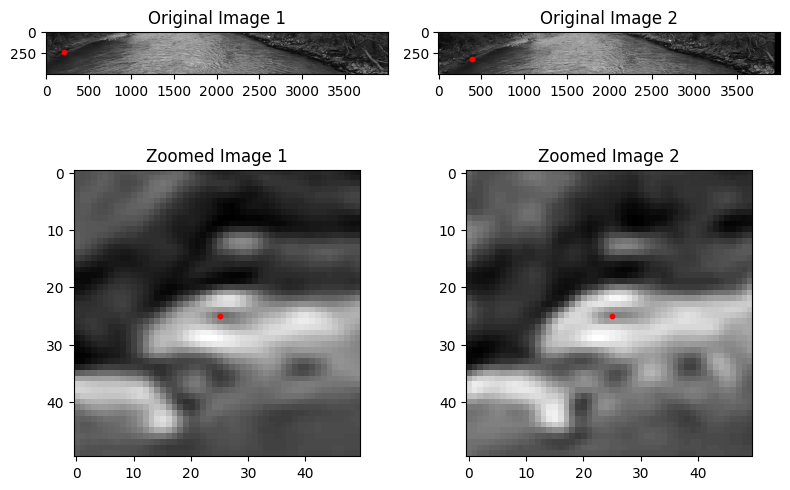

In [ ]:
# Assuming imgs_stripes is a list containing the first and second images
pt = 19
pt1 = filtered_points[pt, 0:2]
pt2 = filtered_points[pt, 2:4]
see_match(imgs_stripes, pt1, pt2, size=50)

In [ ]:
r = 33.4 #cm
d = 21.1 # cm
B = 110.4 #cm
angle_of_view = 73 #degrees
theta_deg  = angle_of_view/2 # degree
theta = np.deg2rad(theta_deg)
print(f"theta = {theta} radians")
print(f"theta = {theta_deg} degrees")
width = imgs_stripes[0].shape[1]
height = imgs_stripes[0].shape[0]
x_0 = width
print(f"x_0 = {x_0}")

theta = 0.6370451769779303 radians
theta = 36.5 degrees
x_0 = 4000


In [ ]:
distances = []

for i in range(filtered_points.shape[0]):
    disparity = np.absolute(filtered_points[i, 4])
    D = (B*x_0) / (2 * np.tan(theta) * (disparity)) # in cm
    D = D/100 # in meter    
    distances.append(D)
    #print(f"Distance to point = {D} m.")

distances=np.array(distances)
#print(distances)

/var/folders/hg/s7by_zc16hd9fxwtj6cx5wrr0000gn/T/ipykernel_19252/3611130802.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  D = (B*x_0) / (2 * np.tan(theta) * (disparity)) # in cm


In [ ]:
points_with_dist = np.array([])
points_with_dist = np.column_stack((filtered_points, distances))
print(points_with_dist.shape)
# Check which rows have 'inf' in the last column
inf_mask = np.isinf(points_with_dist[:, -1])
# Filter out rows with 'inf' in the last column
points_with_dist = points_with_dist[~inf_mask]
print(points_with_dist.shape)

NameError: name 'np' is not defined

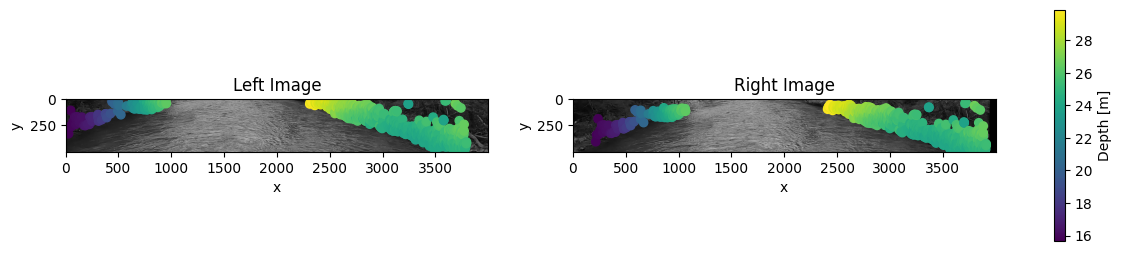

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))


# Plot images and scatter plots
scatter_list = []
for ax, image_rgb, x, y in zip(axes, imgs_stripes, [points_with_dist[:,0], points_with_dist[:,2]], [points_with_dist[:,1], points_with_dist[:,3]]):
    ax.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))
    scatter = ax.scatter(x, y, c=points_with_dist[:,6], cmap='viridis')
    scatter_list.append(scatter)
    ax.set_title('Left Image' if ax == axes[0] else 'Right Image')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

# Add colorbar
plt.colorbar(scatter_list[0], ax=axes, label='Depth [m]')

# Show the plot
plt.show()

In [ ]:
x1_list = points_with_dist[:,0]
y1_list = points_with_dist[:,1]
z_list = points_with_dist[:,6]
# Generate grid points for the whole image
x_grid, y_grid = np.meshgrid(np.arange(width), np.arange(height))

# Flip the y-coordinates
y_grid_flipped = height - y_grid - 1  # Flip the y-coordinates

# Prepare the known points and data
known_points = np.column_stack((x1_list, y1_list))  # Assuming x_coordinates and y_coordinates are your known points

# Interpolate the data over the whole image using spline interpolation
interpolated_data = griddata(known_points, z_list, (x_grid, y_grid_flipped), method='cubic')


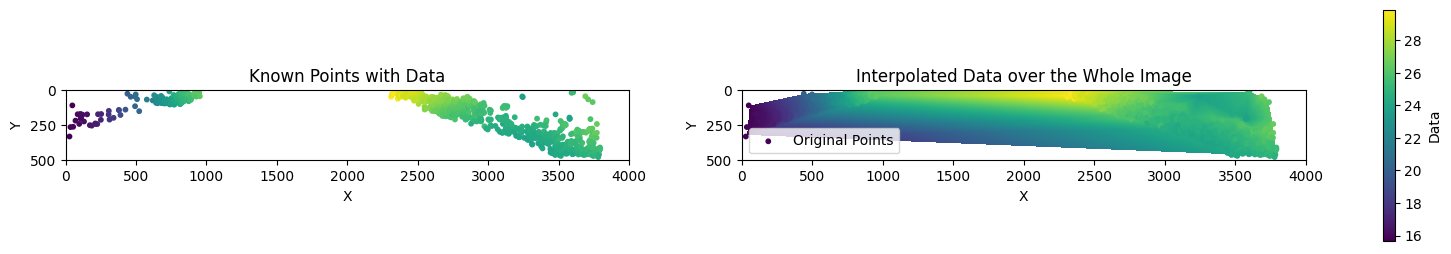

In [ ]:
x1_list = points_with_dist[:,0]
y1_list = points_with_dist[:,1]
z_list = points_with_dist[:,6]
# Generate grid points for the whole image
x_grid, y_grid = np.meshgrid(np.arange(width), np.arange(height))

# Flip the y-coordinates
y_grid_flipped = height - y_grid - 1  # Flip the y-coordinates

# Prepare the known points and data
known_points = np.column_stack((x1_list, y1_list))  # Assuming x_coordinates and y_coordinates are your known points

# Interpolate the data over the whole image using spline interpolation
interpolated_data = griddata(known_points, z_list, (x_grid, y_grid_flipped), method='linear')

# Create a new figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 3))

# Plot the known points with data

scatter = axes[0].scatter(x1_list, y1_list, c=z_list, cmap='viridis',s=10)
axes[0].set_title('Known Points with Data')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
# Create a single colorbar for both subplots
cbar = fig.colorbar(scatter, ax=axes.ravel().tolist(), label='Data')
cbar.ax.set_ylabel('Data', rotation=90)
axes[0].set_xlim(0, width)
axes[0].set_ylim(height, 0)
axes[0].set_aspect('equal')

# Plot the interpolated data
img = axes[1].imshow(interpolated_data, extent=(0, width, height, 0), origin='lower')  # Reverse y-axis direction
axes[1].set_title('Interpolated Data over the Whole Image')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
# Plot the original points on the interpolated data plot
axes[1].scatter(x1_list, y1_list, c=z_list, label='Original Points',s=10)
axes[1].legend()
axes[1].set_aspect('equal')

plt.show()


In [ ]:
#sx_stripes = []

# Loop through the images and select the stripe for each image
#for img in img_l:
#    # Convert the image to a numpy array
#    img_array = np.array(img)

    # Select the stripe using array slicing
#    selected_stripe = img_array[start_y:end_y, start_x:end_x]

    # Append the selected stripe to the list
#    sx_stripes.append(selected_stripe)
sx_stripes = stripes_l

In [ ]:
nb_points = 7
horizontal_band = 500
def keypoint(nb_points, image):
    keypoints = np.empty((0, 2), dtype=np.intp)
    for i in range (0,image.shape[1]-horizontal_band+1 ,horizontal_band):
        selected_stripe= image[:, i : i + horizontal_band]
        corners = cv2.goodFeaturesToTrack(selected_stripe, nb_points,0.5,70)
        corners = np.intp(corners.reshape(-1, 2))
        corners[:, 0] += i# ajouter i a la coordonnée x 
        keypoints = np.concatenate((keypoints, corners), axis=0)
    return keypoints # les paires de coordonnées de chaque keypoints

In [ ]:
def NCC_window(x,y, image): # normalized cross correlation window of 9x9 around our pixel of 
    # Do not forget that if x0-4 or x0+5 is out of the image, we will not take into account this tracking point. 
    #NCC = image[y-4:y+5, x-4:x+5] # rows and columns are switched in the image ( image size is 750x1500)
    NCC = image[y-18:y+19, x-18:x+19]
    return NCC

In [ ]:
def tracking(x0,y0,image, NCC):
    match = 0
    x1 = 0
    y1 = 0
    for x in range(x0-7, x0+7): 
        for y in range(y0-7, y0+7):
            img_comp = NCC_window(x,y,image)
            res = cv2.matchTemplate(img_comp,NCC, cv2.TM_CCORR_NORMED)
            if np.max(res) > match: 
                match = np.max(res)
                x1 = x
                y1 = y
    return(x1, y1)

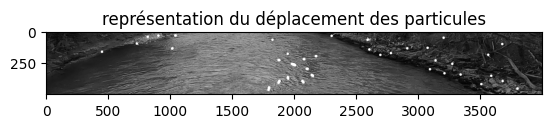

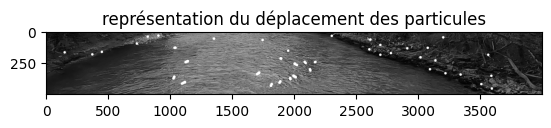

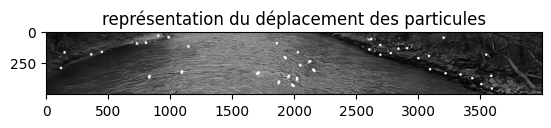

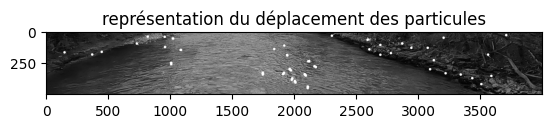

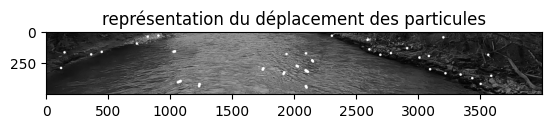

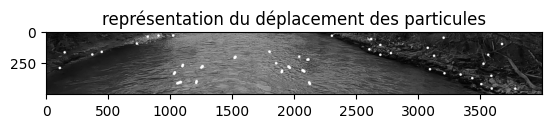

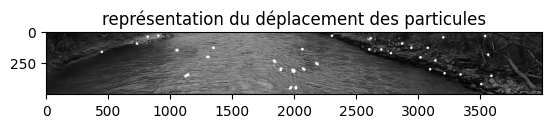

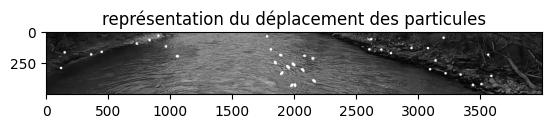

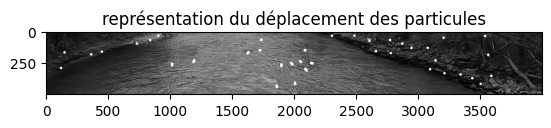

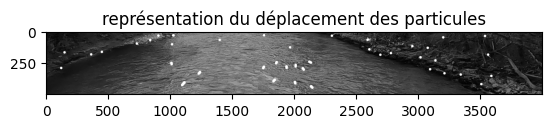

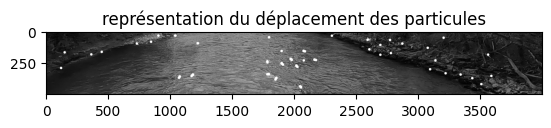

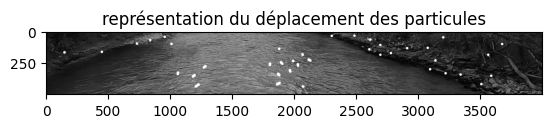

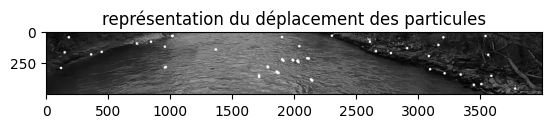

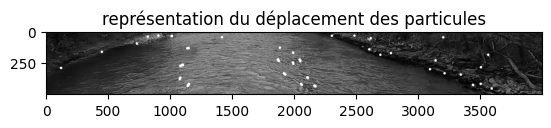

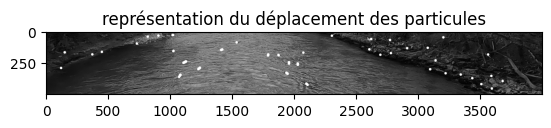

In [ ]:
### celui de sub 5

stats = pd.DataFrame()
img_list=[]
for img_nb in range(0, len(sx_stripes)):
    if img_nb % 20 == 0 and img_nb + 13 < len(sx_stripes): # la deuxieme condition est nécessaire pour pouvoir analyser les images jusqu'à la fin de la video
        corners = keypoint(nb_points, sx_stripes[img_nb])
        coord_track = corners[:,:2].reshape(-1, 2)
        displacement = np.zeros((len(corners),12,2))
        point_i = 0
        point_delete = []
        for x,y in coord_track: 
            for i in range(img_nb + 1, img_nb + 13):
                if x< 32 or x > stripe_width-32 or y < 32 or y > stripe_height-32: 
                    #stock les points à enlever
                    point_delete= np.append(point_delete, point_i)
                    break #skip au prochain point
                NCC = NCC_window(x,y, sx_stripes[i-1])
                displacement[point_i, i-1-img_nb ,:]= x,y
                x,y = tracking(x,y, sx_stripes[i], NCC)
            point_i += 1
        point_delete= point_delete.astype(int)
        displacement = np.delete(displacement,point_delete,0 )
        img_circles = sx_stripes[img_nb].copy()

        direction = []
        length = []
        
        for j in range(displacement.shape[0]):
            x0,y0 = displacement[j,0,:]
            x1,y1 = displacement[j,11,:]
            # recupere angle et taille des vecteurs

            if y1-y0 == 0: #trouver le moyen d'élimier les vecteurs ou on divise par 0
                angle = np.nan
                intensity = np.nan
            else: 
                angle = np.arctan((x1-x0)/(y1-y0))
                intensity = np.sqrt((x1-x0)*(x1-x0) + (y1-y0)*(y1-y0))
            
            direction = np.append(direction, angle)
            length= np.append(length, intensity)

            # représente les vecteurs sur les images
            cv2.circle(img_circles,(int(x0),int(y0)),5,255,-1)
            cv2.circle(img_circles,(int(x1),int(y1)),5,(70,255,212),-1)
            cv2.arrowedLine(img_circles, (int(x0),int(y0)), (int(x1),int(y1)), 255, 20)


        x0 = displacement[:, 0, 0]
        y0 = displacement[:, 0, 1]
        x1 = displacement[:, 11, 0]
        y1 = displacement[:, 11, 1]

        stats_temp = pd.DataFrame({
            'x0': x0,
            'y0': y0,
            'x1': x1,
            'y1': y1,
            'direction': direction,
            'length': length
        })
        stats = pd.concat([stats, stats_temp], ignore_index=True)
        plt.title('représentation du déplacement des particules')
        plt.imshow(img_circles, cmap = 'gray'),plt.show()
        img_list.append(img_circles)

In [ ]:
def convertir_depl_en_m_vertical(point, theta_deg, height, interpolated_data, start_y):
    x1, y1, x2, y2 = point
    #print(f"x1 = {x1}, y1 = {y1}, x2 = {x2}, y2 = {y2}")
    d1 = interpolated_data[y1,x1]  # Extracting the z value corresponding to (x0, y0)
    d2 = interpolated_data[y2,x2]  # Extracting the z value corresponding to (x1, y1)
    #print(f"Z value at (x1, y1) = {d1}, Z value at (x2, y2) = {d2}")
    y1 = y1 + start_y
    y2 = y2 + start_y
    theta_rad = np.deg2rad(theta_deg) # radians
    r = (height/2)/np.tan(theta_rad/2) # pixel
    h1 = np.absolute(y1 - height/2) # pixel
    theta_1 = np.arctan(h1 / r) # radians
    h2 = np.absolute(y2 - height/2) # pixel
    theta_2 = np.arctan(h2 / r) # radians
    angle_diff = theta_1 - theta_2 # radians
    c = np.cos(angle_diff) * d1 # m
    h = np.sin(angle_diff) * d1 # m 
    diff = d2 - c # m
    deplacement_vertical = np.sqrt(diff**2 + h**2) # m
    return deplacement_vertical

def convertir_depl_en_m_horizontal(point, theta_deg, width, interpolated_data, start_x):
    x1, y1, x2, y2 = point
    #print(f"x1 = {x1}, y1 = {y1}, x2 = {x2}, y2 = {y2}")
    d1 = interpolated_data[y1,x1]  # Extracting the z value corresponding to (x0, y0)
    d2 = interpolated_data[y2,x2]  # Extracting the z value corresponding to (x1, y1)
    #print(f"Z value at (x1, y1) = {d1}, Z value at (x2, y2) = {d2}")
    x1 = x1 + start_x
    x2 = x2 + start_x
    theta_rad = np.deg2rad(theta_deg) # radians
    r = (width/2)/np.tan(theta_rad/2) # pixel
    w1 = np.absolute(x1 - width/2) # pixel
    theta_1 = np.arctan(w1 / r) # radians
    w2 = np.absolute(x2 - width/2) # pixel
    theta_2 = np.arctan(w2 / r) # radians
    angle_diff = theta_1 - theta_2 # radians
    c = np.cos(angle_diff) * d1 # m
    h = np.sin(angle_diff) * d1 # m 
    diff = d2 - c # m
    deplacement_horizontal = np.sqrt(diff**2 + h**2) # m
    return deplacement_horizontal

def depl_total(point, theta_deg_vert=58, theta_deg_hor=73, width=width, height=height, interpolated_data=interpolated_data, start_x=start_x, start_y=start_y):
    depl_vert_m = convertir_depl_en_m_vertical(point, theta_deg_vert, height, interpolated_data, start_y)
    depl_horiz_m = convertir_depl_en_m_horizontal(point, theta_deg_hor, width, interpolated_data, start_x)
    #print(f"deplacement vertical: {depl_vert_m} m")
    #print(f"deplacement horizontal: {depl_horiz_m} m")
    tot_depl = np.sqrt(depl_vert_m**2 + depl_horiz_m**2)
    #print(f"deplacement total = {tot_depl}")
    return tot_depl

deplacement = []
tracked_points = stats[['x0', 'y0', 'x1', 'y1']].values
for points in tracked_points:
    #tracked_point_1 = tracked_points[80]
    point = points.astype(int)
    #print(depl_total(point))
    deplacement.append(depl_total(point))
#deplacement = [x for x in deplacement if not np.isnan(x)]
#print(deplacement)
#print(np.mean(deplacement))

In [ ]:
stats['dep_m']= deplacement

In [ ]:
def drop_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   outliers_dropped = not_outliers.dropna().reset_index()

   return outliers_dropped

In [ ]:
stats = drop_outliers_IQR(stats)

/var/folders/hg/s7by_zc16hd9fxwtj6cx5wrr0000gn/T/ipykernel_19252/699023897.py:4: RankWarning: Polyfit may be poorly conditioned
  mymodel = np.poly1d(np.polyfit(x, y, 19))
/var/folders/hg/s7by_zc16hd9fxwtj6cx5wrr0000gn/T/ipykernel_19252/699023897.py:22: RankWarning: Polyfit may be poorly conditioned
  mymodel = np.poly1d(np.polyfit(x, y_pix, 16))


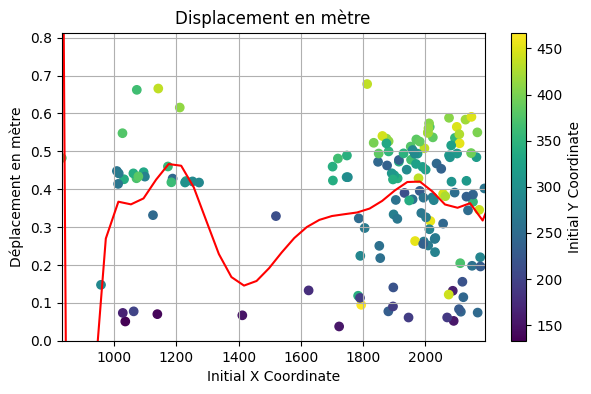

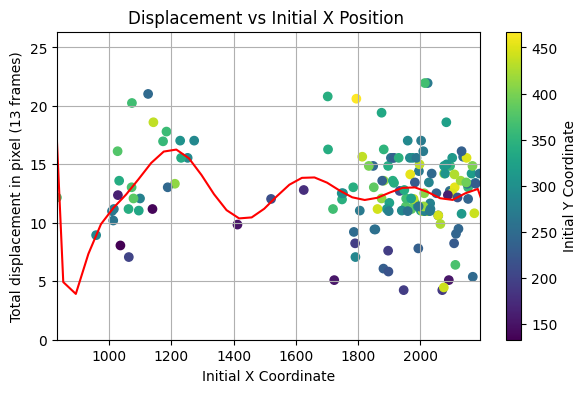

In [ ]:
x = stats.x0
y = stats.dep_m

mymodel = np.poly1d(np.polyfit(x, y, 19))
myline = np.linspace(5, 4000, 100)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.scatter(x, y, c=stats.y0, cmap='viridis')
plt.plot(myline, mymodel(myline), color='red')
#plt.scatter(stats.x0, stats.length)
plt.xlabel("Initial X Coordinate")
plt.ylabel("Déplacement en mètre")
plt.title("Displacement en mètre")
plt.colorbar(label='Initial Y Coordinate')
plt.ylim(bottom=0, top=np.max(y) + 0.2*np.max(y))
plt.xlim(left = np.min(x), right= np.max(x))
plt.grid(True)


y_pix = stats.length

mymodel = np.poly1d(np.polyfit(x, y_pix, 16))
myline = np.linspace(5, 4000, 100)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 2)
plt.scatter(x, y_pix, c=stats.y0, cmap='viridis')
plt.plot(myline, mymodel(myline), color='red')
#plt.scatter(stats.x0, stats.length)
plt.xlabel("Initial X Coordinate")
plt.ylabel("Total displacement in pixel (13 frames)")
plt.title("Displacement vs Initial X Position ")
plt.colorbar(label='Initial Y Coordinate')
plt.ylim(bottom=0, top=np.max(y_pix) + 0.2*np.max(y_pix))
plt.xlim(left = np.min(x), right= np.max(x))
plt.grid(True)


# Affichage de la dernière image de img_list
#plt.subplot(1, 2, 2)
#plt.title('représentation du déplacement des particules')
#plt.imshow(img_list[-1], cmap='gray')
plt.show() 